# **Proyecto Inteligencia Artificial II**
# **Redes Neuronales al Volante**

## Juan José Arango Serrano
## Cristian Camacho
## Camilo Sanmiguel

In [ ]:
#@title COLAB
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Inteligencia Artificial 2/Mis Notebooks/Proyecto')
print(os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Inteligencia Artificial 2/Mis Notebooks/Proyecto


In [ ]:
#@title Liberias
%tensorflow_version 1.x
#import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import tensorflow
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D,TimeDistributed,GRU,Activation,InputLayer, MaxPooling2D, Dropout, Flatten, Dense, LSTM, Reshape, Input, Concatenate, ZeroPadding2D, GlobalMaxPool2D, BatchNormalization
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras import initializers,optimizers
from keras.utils import to_categorical
from sklearn.utils import shuffle
import cv2
import random
WIDTH = 150
HEIGHT = 100

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
#@title Lectura del dataset
train_data = np.load('/content/drive/MyDrive/Inteligencia Artificial 2/Mis Notebooks/Proyecto/data/training_data-1.npy', allow_pickle=True) 
for data in range(2,25):
  train_data =  np.concatenate((train_data,np.load('data/training_data-{}.npy'.format(data),allow_pickle=True)))

print ("Training Data: ", train_data.shape)
train_data=shuffle(train_data)

Training Data:  (120000, 2)


In [ ]:
#@title Organización de las etiquetas

def dataset():
  teclas = []
  for data in train_data:
    imagen = data[0]
    tecla = data[1]
    teclas.append(tecla)

  teclas = np.array(teclas)

  df = pd.DataFrame(teclas, columns = ['W','S','A','D','WA','WD','NT'])
  
  return df

df = dataset()
print(df.head())

   W  S  A  D  WA  WD  NT
0  0  0  0  0   1   0   0
1  1  0  0  0   0   0   0
2  1  0  0  0   0   0   0
3  0  0  0  0   0   1   0
4  0  0  0  0   1   0   0


Cantidad de W : 21500
Cantidad de S : 913
Cantidad de A : 7204
Cantidad de D : 11097
Cantidad de WA : 17836
Cantidad de WD : 15100
Cantidad de NT : 7037


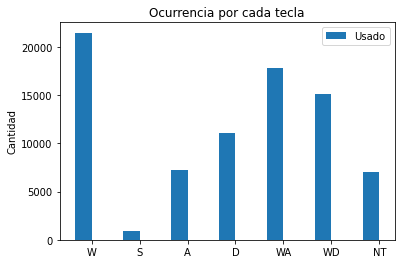

In [ ]:
#@title Distribución de los datos por cada clase
def grafica():
  labels = ['W','S','A','D','WA','WD','NT']
  presente=[]
  no_presente=[]
  for l in labels:
    cantidad_p = df[df[l]==1].shape[0]
    cantidad_np = df[df[l]==0].shape[0]
    presente.append(cantidad_p)
    no_presente.append(cantidad_np)
    print("Cantidad de "+str(l)+" : "+str(cantidad_p))

  x = np.arange(len(labels))  # the label locations

  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, presente, width, label='Usado')
  #rects2 = ax.bar(x + width/2, no_presente, width, label='No Usado')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Cantidad')
  ax.set_title('Ocurrencia por cada tecla')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

grafica()


Cantidad de W : 21500
Cantidad de S : 913
Cantidad de A : 7204
Cantidad de D : 11097
Cantidad de WA : 17836
Cantidad de WD : 15100
Cantidad de NT : 7037


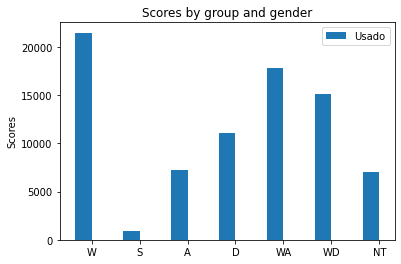

In [ ]:
#@title Se reduce la cantidad de W
borrados = 0
remove = []
lista = list(df['W'])
cantidad = df[df['W']==1].shape[0]
for i in range(len(lista)):
  if lista[i] == 1:
    remove.append(i)
    borrados += 1
  
  if(borrados == (cantidad-23000)):
      break

train_data = np.delete(train_data, remove, axis=0)
df = dataset()
grafica()

In [ ]:
#@title Train y Test split
train = train_data[:-round(len(train_data)*0.20)] 
test = train_data[-round(len(train_data)*0.20):]
print("tamaño balanceado: ", train_data.shape)
print("train: ", train.shape)
print("test: ", test.shape)


tamaño balanceado:  (80687, 2)
train:  (64550, 2)
test:  (16137, 2)


In [ ]:
#@title Arquitectura CNN
def nvidia():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(WIDTH, HEIGHT,1),activation='elu'))
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(7)) # 7 Salidas diferentes.
  model.compile(Adam(lr=0.001), loss = 'mse', metrics = ['accuracy'])
  return model
  
model = nvidia()
print (model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 48, 24)        624       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 22, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 9, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 7, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 5, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_______________________________________

In [ ]:
#@title Generador de batch
def batch_generator(train_data_to_generate, batch_size):
  while True:
    batch_img = []
    batch_ch = []

    for i in range(batch_size):
      random_index = random.randint(0, len(train_data_to_generate)-1)
      image, choice = train_data_to_generate[random_index]
      
      image = image.reshape(WIDTH,HEIGHT,1)

      batch_img.append(image)
      batch_ch.append(choice)
    yield (np.asarray(batch_img), np.asarray(batch_ch))

In [ ]:
#@title Entrenamiento CNN
history = model.fit_generator(batch_generator(train,300),
                              steps_per_epoch = 100, 
                              epochs = 25,
                              validation_data = batch_generator(test, 100),
                              validation_steps = 50,
                              verbose = 1, 
                              shuffle=1)



Epoch 1/25
100/100 [==============================] - 7s 69ms/step - loss: 0.5179 - accuracy: 0.2286 - val_loss: 0.1165 - val_accuracy: 0.2900
Epoch 2/25
100/100 [==============================] - 5s 47ms/step - loss: 0.1111 - accuracy: 0.3419 - val_loss: 0.1044 - val_accuracy: 0.3512
Epoch 3/25
100/100 [==============================] - 5s 47ms/step - loss: 0.1044 - accuracy: 0.4194 - val_loss: 0.1039 - val_accuracy: 0.3998
Epoch 4/25
100/100 [==============================] - 5s 48ms/step - loss: 0.0962 - accuracy: 0.4951 - val_loss: 0.0998 - val_accuracy: 0.4248
Epoch 5/25
100/100 [==============================] - 5s 48ms/step - loss: 0.0900 - accuracy: 0.5455 - val_loss: 0.0993 - val_accuracy: 0.5016
Epoch 6/25
100/100 [==============================] - 5s 48ms/step - loss: 0.0840 - accuracy: 0.5929 - val_loss: 0.0921 - val_accuracy: 0.5680
Epoch 7/25
100/100 [==============================] - 5s 48ms/step - loss: 0.0781 - accuracy: 0.6389 - val_loss: 0.0868 - val_accuracy: 0.567

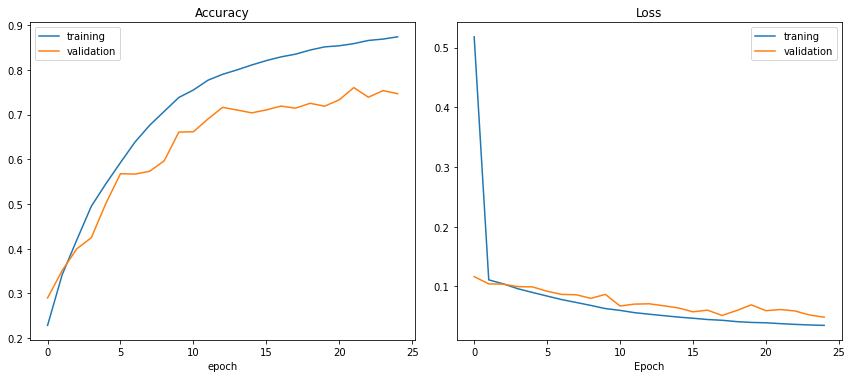

In [ ]:
#@title Comportamiento entreno
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.tight_layout()
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].legend(['training', 'validation'])
axs[0].set_title('Accuracy')
axs[0].set_xlabel('epoch')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].legend(['traning', 'validation'])
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')

plt.show()

Actual:  [0, 0, 0, 0, 1, 0, 0]
Prediction:  [[-0.01679559 -0.01836452  0.00513498 -0.07125599  1.0464022  -0.04022215
  -0.01719847]]


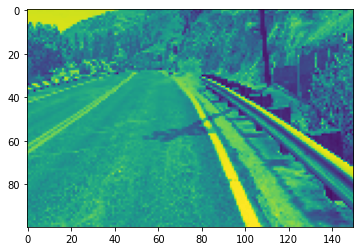

In [ ]:
#@title Test CNN

img_prueba, tecla_prueba = test [random.randint(0,len(test)-1)]
plt.imshow(img_prueba)
print ("Actual: ", tecla_prueba)
img_prueba = img_prueba.reshape(-1,WIDTH,HEIGHT,1)

print ("Prediction: ", model.predict(img_prueba))

In [ ]:
#@title Evaluación del modelo
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=30)
print("test loss, test acc:", results)

Evaluate on test data
16137/16137 [==============================] - 2s 116us/step
test loss, test acc: [0.05498998965164236, 0.7530519962310791]


In [ ]:
model.save('MODELO.h5')